# Вариационный автоэнкодер

Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114

Подключаем необходимые библиотеки

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.datasets import fashion_mnist

## Задание 1 Реализуйте транспонированную свертку, чтобы из исходной матрицы e (2x2) с ядром t (3x3) получить матрицу d (4x4). Проверьте работу с произвольными матрицами.

In [ ]:
def tconv_sq(e,t):
  h, w = t.shape
  Y = np.zeros((e.shape[0] + h - 1, e.shape[1] + w - 1))
  for i in range(e.shape[0]):
      for j in range(e.shape[1]):
          Y[i: i + h, j: j + w] += e[i, j] * t
  return Y

In [ ]:
a = np.random.randint(1, 10, (2,2))
b = np.random.randint(1, 10, (3,3))

In [ ]:
a

array([[3, 5],
       [1, 4]])

In [ ]:
b

array([[2, 7, 9],
       [8, 6, 2],
       [6, 1, 2]])

In [ ]:
tconv_sq(a,b)

array([[ 6., 31., 62., 45.],
       [26., 73., 73., 46.],
       [26., 71., 37., 18.],
       [ 6., 25.,  6.,  8.]])

## Задание 2 Реализуйте транспонированную свертку, чтобы из исходной матрицы e (2x3) с ядром t (3x3) получить матрицу d (5x7). Проверьте работу с произвольными матрицами.

In [ ]:
def tconv_rec(e,t):
  h, w = t.shape
  Y = np.zeros((e.shape[0] + h, e.shape[1] + w + 1))
  for i in range(0, e.shape[0]):
      for j in range(e.shape[1]):
          Y[2*i: 2*i + h, 2*j: 2*j + w] += e[i, j] * t
  return Y

In [ ]:
a = np.random.randint(1, 10, (2,3))
b = np.random.randint(1, 10, (3,3))

In [ ]:
a

array([[1, 1, 3],
       [2, 1, 5]])

In [ ]:
b

array([[5, 4, 5],
       [3, 8, 2],
       [7, 5, 2]])

In [ ]:
tconv_rec(a,b)

array([[ 5.,  4., 10.,  4., 20., 12., 15.],
       [ 3.,  8.,  5.,  8., 11., 24.,  6.],
       [17., 13., 24.,  9., 53., 35., 31.],
       [ 6., 16.,  7.,  8., 17., 40., 10.],
       [14., 10., 11.,  5., 37., 25., 10.]])

## Датасет Fashion MNIST

Набор данных Fashion MNIST — это большая свободно доступная база данных изображений моды, которая обычно используется для обучения и тестирования различных систем машинного обучения.

Загрузим данные

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Визуализируем изображения одежды

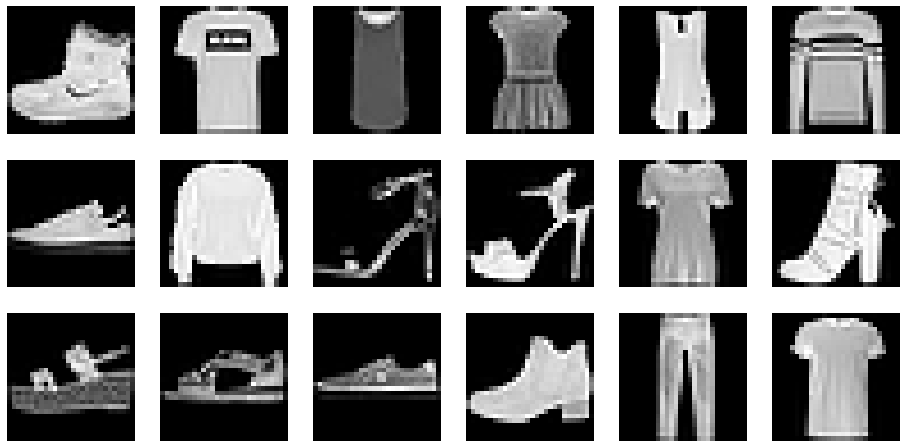

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

### Вопрос 1 Сколько и какие классы присутствуют в датасете? Сколько изображений в датасете?

#### Ваш ответ

In [ ]:
print('Количество классов:', len(np.unique(y_train)))

Количество классов: 10


In [ ]:
print('Общее количество изображений', len(y_train)+len(y_test))

Общее количество изображений 70000


##Задание 3 Масштабируйте яркость изображений (от 0 до 1).
#### Примечание:
Переведите при масштабировании данные в тип float

In [ ]:
x_train = (x_train / 255).astype(float)
x_test = (x_test / 255).astype(float)

## Стандартная полносвязная модель VAE
Давайте определим модель VAE с полносвязным многослойным перцептроном (MLP) для сетей кодировщика и декодера.

In [ ]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train_standard.shape, x_test_standard.shape

((60000, 784), (10000, 784))

## Encoder

Установим входную, промежуточную и латентную размерность кодировщика

In [ ]:
original_dim = 784
latent_dim = 2
intermediate_dim = 256

## Задание 4 Реализуйте полносвязную модель для построения кодировщика с 2 слоями, на выходе которой ожидаются 2 параметра

In [ ]:
def make_encoder(original_dim, intermediate_dim, latent_dim):
    x = Input(shape=original_dim, name='encoder_input')
    hidden = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(hidden)
    z_log_var = Dense(latent_dim, name='z_log_var')(hidden)
    return Model(inputs=x, outputs=[z_mean, z_log_var],
                name="mlp_encoder")


encoder = make_encoder(original_dim, intermediate_dim, latent_dim)

### Скрытая стохастическая переменная VAE

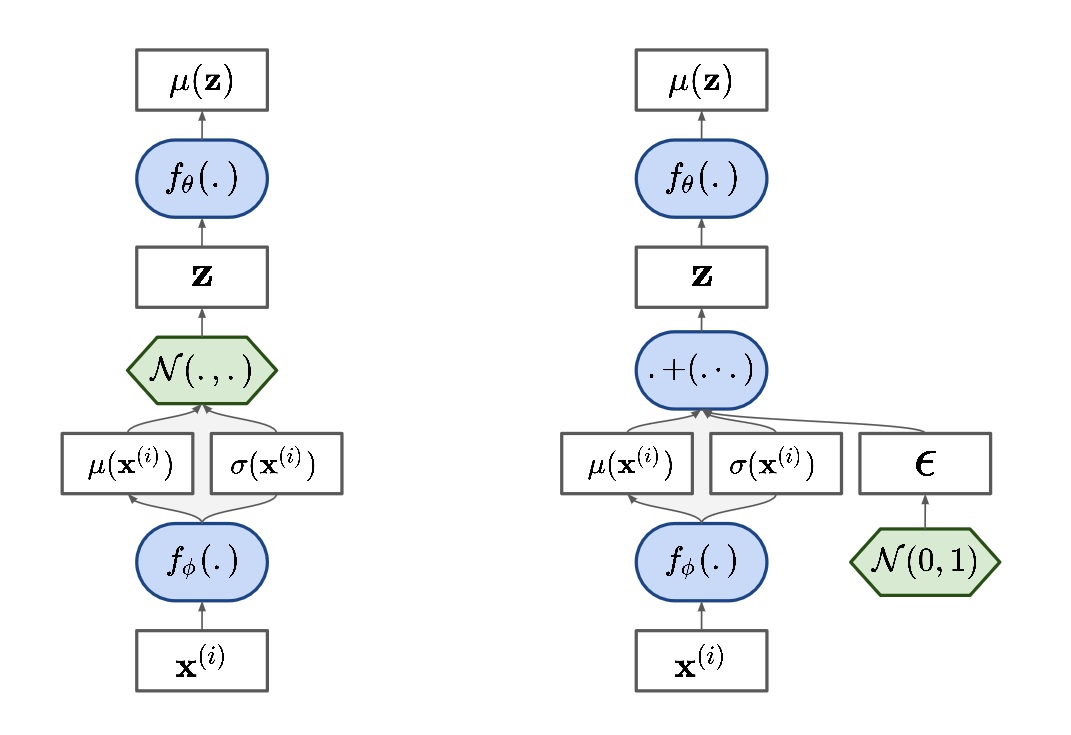

Мы используем прием репараметризации, чтобы определить случайную величину z, которая зависит от входного изображения x, следующим образом:

$$ z \sim \mathcal{N}(\mu_z(x), \sigma_z(x)) $$

Репараметризация определяет $z$ следующим образом:

$$ z = \mu_z(x) + \sigma_z(x) \cdot \epsilon$$

где

$$ \epsilon \sim \mathcal{N}(0, 1) $$

Таким образом, зависимость между $z$ и $x$ является детерминированной и дифференцируемой. Случайность $z$ проистекает только из $\epsilon$ только для данного $x$.

Обратите внимание, что на практике выход сети кодировщика параметризует $log(\sigma^2_z(x)$ вместо $\sigma_z(x)$. Взятие экспоненты $log(\sigma^2_z(x)$ гарантирует положительное стандартное отклонение от необработанного вывода сети.

## Задание 5 Дополните функции репараметризации так, чтобы добавлялась соответствующая формуле выше случайная составляющая
#### Примечание: не забудьте, что энкодер возвращает логарифмическое значение для дисперсии, а в выражении нужно стандартное отклонение

In [ ]:
def sampling_func(inputs):
    z_mean, z_log_var = inputs
    batch_size = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,),
                        name="latent_sampler")

### Примечание:
Мы использовали Lambda-слой с функцией, сэмплирующей из случайной добавки $ \epsilon \sim \mathcal{N}(0, 1) $, которая явно требует размер батча. Во всех моделях, в которых присутствует этот слой, мы теперь вынуждены передавать именно такой размер батча (то есть в encoder и vae).

##Декодер

Теперь реализуем декодер

## Задание 6 Сделайте обратное изменение размерностей с помощью полносвязной сети для определения декодера. На последнем слое использовать сигмоидную функцию активации.

In [ ]:
def make_decoder(latent_dim, intermediate_dim, original_dim):
    decoder_input = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(original_dim, activation='sigmoid')(x)
    return Model(decoder_input, x, name="mlp_decoder")

decoder = make_decoder(latent_dim, intermediate_dim, original_dim)

По умолчанию выходные данные декодера имеют случайные веса и выходной шум:

1/1 [==============================] - 2s 2s/step


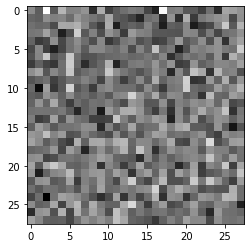

In [ ]:
random_z_from_prior = np.random.normal(loc=0, scale=1, size=(1, latent_dim))
generated = decoder.predict(random_z_from_prior)
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)

Сгенерированное изображение представляет собой двумерный шум: между значениями пикселей нет явных пространственных зависимостей. Это отражает отсутствие предшествующей структуры в произвольно инициализируемой полносвязной сети декодера.


Давайте теперь подключим кодировщик и декодер через стохастическую скрытую переменную $z$, чтобы получить полную архитектуру VAE. Функция потерь представляет собой отрицательный Evidence lower bound (ELBO)* задачи вариационного вывода:

*https://en.wikipedia.org/wiki/Evidence_lower_bound

In [ ]:
def make_vae(input_shape, encoder, decoder, sampling_layer):
    # Создайте архитектуру модели, собрав кодировщик, стохастическую скрытую переменную и декодер:
    x = Input(shape=input_shape, name="input")
    z_mean, z_log_var = encoder(x)
    z = sampling_layer([z_mean, z_log_var])
    x_decoded_mean = decoder(z)
    vae = Model(x, x_decoded_mean)

    # Определение функции потерь для VAE
    xent_loss = original_dim * metrics.binary_crossentropy(
        Flatten()(x), Flatten()(x_decoded_mean))
    kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    vae_loss = tf.reduce_mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

vae = make_vae((original_dim,), encoder, decoder,
               sampling_layer=sampling_layer)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 mlp_encoder (Functional)       [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2)]                                                       
                                                                                                  
 latent_sampler (Lambda)        (None, 2)            0           ['mlp_encoder[1][0]',            
                                                                  'mlp_encoder[1][1]']            
                                                                                            

## Задание 7 Обучите полученный вариационный автоэнкодер и постройте кривые обучения для функции потерь (для валидации используйте тестовую выборку)

In [ ]:
#Ваш код
history = vae.fit(x_train_standard, epochs=50, batch_size=100, validation_data=(x_test_standard, None))

Epoch 1/50
600/600 [==============================] - 3s 3ms/step - loss: 260.0505 - val_loss: 261.9288
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 259.9856 - val_loss: 262.3600
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 259.9305 - val_loss: 261.9261
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 259.9166 - val_loss: 262.1225
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 259.8338 - val_loss: 261.7575
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 259.8353 - val_loss: 261.9284
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 259.7481 - val_loss: 262.1917
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 259.7408 - val_loss: 261.8809
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 259.6587 - val_loss: 261.5223
Epoch 10/50
600/600 [==============================] - 2s 3ms/st

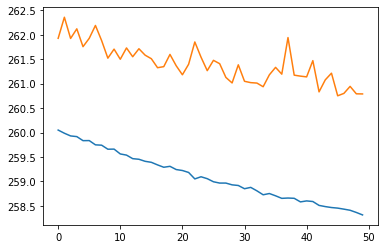

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### Вопрос 2 Что можно наблюдать по полученным кривым обучения? С чем это может быть связано?



#### Ваш ответ

Наблюдаем нестабильность на валидационной выборке, возможно переобучение.

Сохраним и загрузим модель

In [ ]:
vae.save_weights("standard_weights.h5")

In [ ]:
vae.load_weights("standard_weights.h5")

Выбирая случайный скрытый вектор из предыдущего распределения и передавая его декодеру, мы можем эффективно выбирать из модели изображения, обученной VAE:

## Задание 8. Сгенерируйте несколько изображений разных классов и посмотрите, из каких скрытых векторов они получаются.

array([[0.7774276, 0.7745555]], dtype=float32)

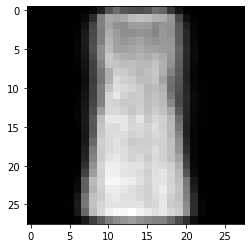

In [ ]:
random_z_from_prior = np.random.normal(size=(1, latent_dim)).astype("float32")
generated = decoder(random_z_from_prior).numpy()
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
#Ваше решение
random_z_from_prior

array([[-1.9447315,  0.7677197]], dtype=float32)

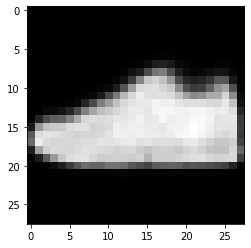

In [ ]:
random_z_from_prior = np.random.normal(size=(1, latent_dim)).astype("float32")
generated = decoder(random_z_from_prior).numpy()
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
#Ваше решение
random_z_from_prior

Сгенерированные изображения размыты, но для представления образцов из 10 категорий предметов моды требуется захват глобальной организации пикселей. Пространственная структура изучена и присутствует только в весовых коэффициентах декодера.

##2D-график классов изображений в скрытом пространстве
Мы также можем использовать кодировщик, чтобы настроить визуализацию распределения тестового набора в скрытом двумерном пространстве модели VAE. Далее цвета показывают метки истинного класса из тестовых образцов.

Обратите внимание, что VAE — это неконтролируемая модель: во время обучения она не использовала информацию о метках. Однако мы можем заметить, что двумерное скрытое пространство в значительной степени структурировано вокруг категорий изображений, используемых в обучающем наборе.

In [ ]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

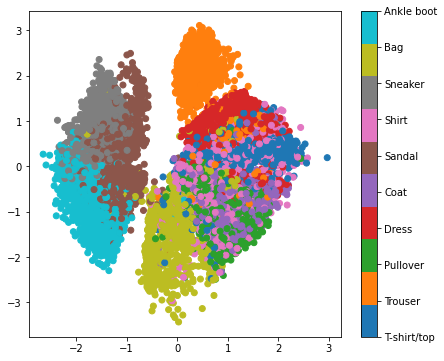

In [ ]:
x_test_encoded, x_test_encoded_log_var = encoder(x_test_standard)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

## Задание 10 Видно, что метки классов 5, 7 и 9 сгруппированы в кластер скрытого пространства. Используйте matplotlib, чтобы отобразить некоторые образцы из каждого из этих 3 классов и узнать, почему они были сгруппированы вместе по модели VAE.

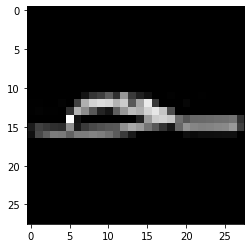

In [ ]:
##Ваше решение
plt.imshow(x_test[(y_test[:20]==5).argmax()].reshape(28, 28), cmap=plt.cm.gray)

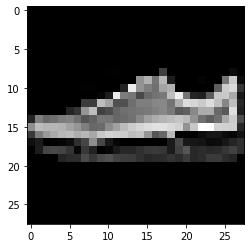

In [ ]:
plt.imshow(x_test[(y_test[:20]==7).argmax()].reshape(28, 28), cmap=plt.cm.gray)

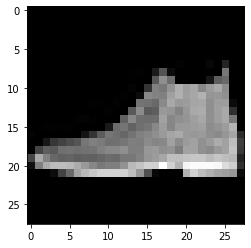

In [ ]:
plt.imshow(x_test[(y_test[:20]==9).argmax()].reshape(28, 28), cmap=plt.cm.gray)

####Ваш ответ

Вижим, что для каждого элемента из класса 5,7 и 9 есть горизонтальная линия в пределах от 15 до 20 пикселей по у. При этом эти элементы отличаются высотой поэтому не сильно перемешаны друг с другом.

## Задание 11 Объясните с помощью matplotlib, почему классы 0, 4 и 6 кажутся трудными для распутывания в этом скрытом двумерном пространстве, обнаруженном моделью VAE?

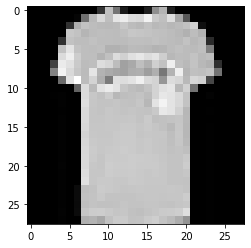

In [ ]:
##Ваше решение
plt.imshow(x_test[(y_test[:20]==0).argmax()].reshape(28, 28), cmap=plt.cm.gray)

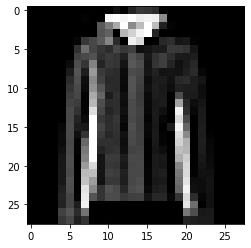

In [ ]:
plt.imshow(x_test[(y_test[:20]==4).argmax()].reshape(28, 28), cmap=plt.cm.gray)

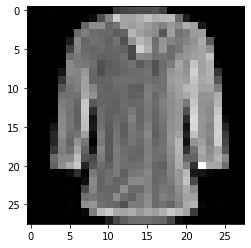

In [ ]:
plt.imshow(x_test[(y_test[:20]==6).argmax()].reshape(28, 28), cmap=plt.cm.gray)

####Ваш ответ

Видим, что все элементы этого класса имеют практически одинаковый вид. Единственным отличием является длина рукова, что трудно отличимо.

### Вопрос 3 Можно заметить, что глобальная двумерная форма закодированного набора данных является приблизительно сферической со значениями с максимальным радиусом размера 3. Где вы можете объяснить, откуда взялась форма этого маргинального скрытого распределения?

#### Ваш ответ

Данные преобразуются в z с помощью нахождения среднего и стандратного отклонения, что и влияет на радиус получаемого рисунка.

### 2D-панель образцов из коллектора VAE

Следующие линейно расположенные координаты на единичном квадрате были преобразованы с помощью обратной CDF (ppf) гауссовой функции для получения значений скрытых переменных z. Это позволяет использовать квадратное расположение панелей, которое охватывает гауссовский априор скрытого пространства.

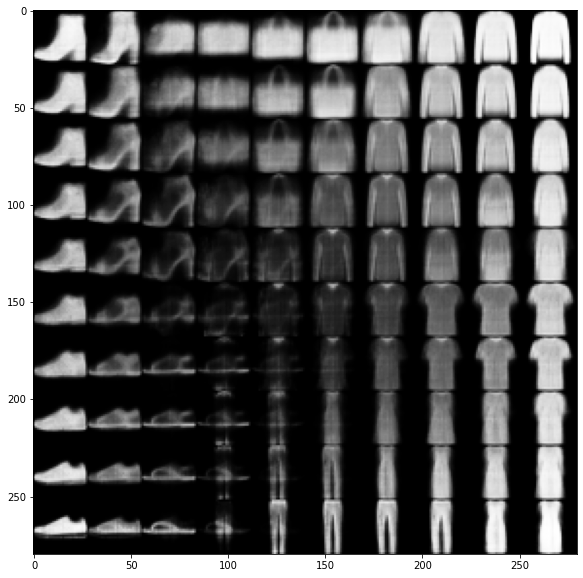

In [ ]:
n = 10  # фигура размером 10x10 изображений
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder(z_sample).numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Задание 12 Увеличьте число эпох обучения до 300. Затем визуализируйте кривые обучения, скрытое пространство и несколько примеров генерируемых изображений.

In [ ]:
##Ваше решение
vae = make_vae((original_dim,), encoder, decoder,
               sampling_layer=sampling_layer)
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 mlp_encoder (Functional)       [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2)]                                                       
                                                                                                  
 latent_sampler (Lambda)        (None, 2)            0           ['mlp_encoder[2][0]',            
                                                                  'mlp_encoder[2][1]']            
                                                                                            

In [ ]:
#Ваш код
history = vae.fit(x_train_standard, epochs=300, batch_size=100, validation_data=(x_test_standard, None))

Epoch 1/300
600/600 [==============================] - 3s 4ms/step - loss: 258.3483 - val_loss: 261.5214
Epoch 2/300
600/600 [==============================] - 2s 3ms/step - loss: 258.2794 - val_loss: 260.6248
Epoch 3/300
600/600 [==============================] - 2s 3ms/step - loss: 258.2452 - val_loss: 260.9895
Epoch 4/300
600/600 [==============================] - 2s 3ms/step - loss: 258.2769 - val_loss: 260.9189
Epoch 5/300
600/600 [==============================] - 2s 3ms/step - loss: 258.2323 - val_loss: 260.4872
Epoch 6/300
600/600 [==============================] - 2s 3ms/step - loss: 258.2259 - val_loss: 260.6664
Epoch 7/300
600/600 [==============================] - 2s 3ms/step - loss: 258.1774 - val_loss: 260.6250
Epoch 8/300
600/600 [==============================] - 2s 3ms/step - loss: 258.1916 - val_loss: 260.8101
Epoch 9/300
600/600 [==============================] - 2s 3ms/step - loss: 258.1190 - val_loss: 260.6625
Epoch 10/300
600/600 [==============================] -

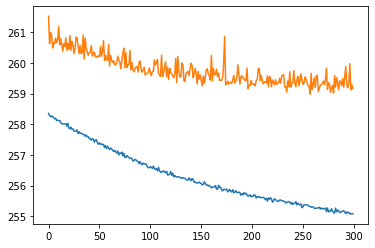

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

array([[ 0.02064794, -1.5205913 ]], dtype=float32)

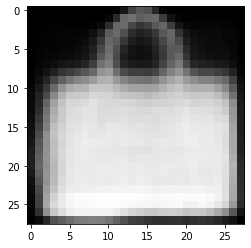

In [ ]:
random_z_from_prior = np.random.normal(size=(1, latent_dim)).astype("float32")
generated = decoder(random_z_from_prior).numpy()
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
#Ваше решение
random_z_from_prior

array([[ 0.6025611, -2.0069063]], dtype=float32)

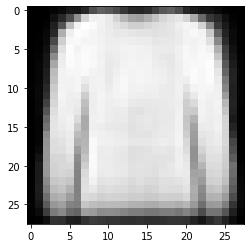

In [ ]:
random_z_from_prior = np.random.normal(size=(1, latent_dim)).astype("float32")
generated = decoder(random_z_from_prior).numpy()
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
#Ваше решение
random_z_from_prior

In [ ]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

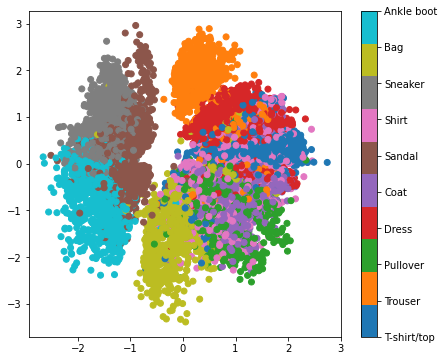

In [ ]:
x_test_encoded, x_test_encoded_log_var = encoder(x_test_standard)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

## Задание 13 Сделайте выводы о проведенной работе

#### Ваши выводы)

В данной работе был создан вариационный энкодер, который позволяет преобразовать данные из многоразмерного в низкоразмерное, а также обратного декодирования. VAE позволяет моделировать распределение данных как стандартное нормальное распределение с центром вокруг 0.

В процессе работы удалось создать архитектуру автоэнкодера так, чтобы сжатое представление представляло существенные черты исходных входных данных, то есть классы были отличимы.

## Допзадание

### Задание 1 Датасет MNIST

Реализуйте и исследуйте модель вариационного автокодировщика для датасета MNIST

In [ ]:
#Ваше решение
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


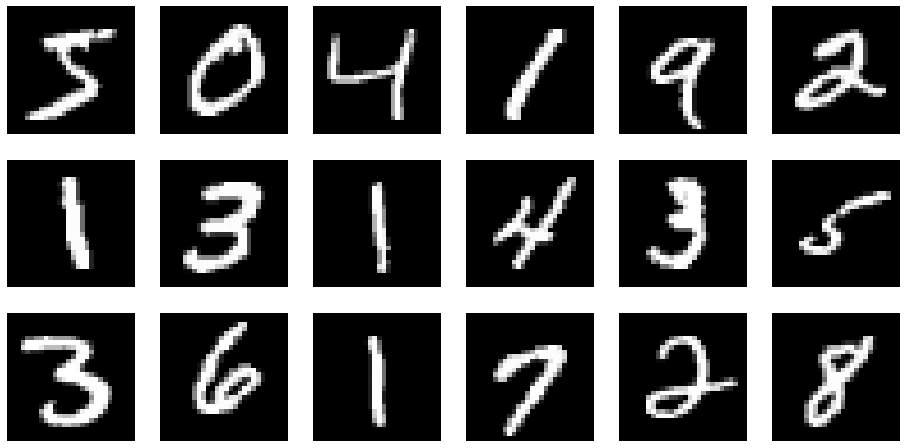

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [ ]:
print('Количество классов:', len(np.unique(y_train)))

Количество классов: 10


In [ ]:
print('Общее количество изображений', len(y_train)+len(y_test))

Общее количество изображений 70000


In [ ]:
x_train = (x_train / 255).astype(float)
x_test = (x_test / 255).astype(float)

In [ ]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train_standard.shape, x_test_standard.shape

((60000, 784), (10000, 784))

In [ ]:
original_dim = 784
latent_dim = 2
intermediate_dim = 256

In [ ]:
def make_encoder(original_dim, intermediate_dim, latent_dim):
    x = Input(shape=original_dim, name='encoder_input')
    hidden = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(hidden)
    z_log_var = Dense(latent_dim, name='z_log_var')(hidden)
    return Model(inputs=x, outputs=[z_mean, z_log_var],
                name="mlp_encoder")


encoder = make_encoder(original_dim, intermediate_dim, latent_dim)

In [ ]:
def sampling_func(inputs):
    z_mean, z_log_var = inputs
    batch_size = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,),
                        name="latent_sampler")

In [ ]:
def make_decoder(latent_dim, intermediate_dim, original_dim):
    decoder_input = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(original_dim, activation='sigmoid')(x)
    return Model(decoder_input, x, name="mlp_decoder")

decoder = make_decoder(latent_dim, intermediate_dim, original_dim)

In [ ]:
def make_vae(input_shape, encoder, decoder, sampling_layer):
    # Создайте архитектуру модели, собрав кодировщик, стохастическую скрытую переменную и декодер:
    x = Input(shape=input_shape, name="input")
    z_mean, z_log_var = encoder(x)
    z = sampling_layer([z_mean, z_log_var])
    x_decoded_mean = decoder(z)
    vae = Model(x, x_decoded_mean)

    # Определение функции потерь для VAE
    xent_loss = original_dim * metrics.binary_crossentropy(
        Flatten()(x), Flatten()(x_decoded_mean))
    kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    vae_loss = tf.reduce_mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

vae = make_vae((original_dim,), encoder, decoder,
               sampling_layer=sampling_layer)
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 mlp_encoder (Functional)       [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2)]                                                       
                                                                                                  
 latent_sampler (Lambda)        (None, 2)            0           ['mlp_encoder[0][0]',            
                                                                  'mlp_encoder[0][1]']            
                                                                                            

In [ ]:
#Ваш код
history = vae.fit(x_train_standard, epochs=50, batch_size=100, validation_data=(x_test_standard, None))

Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: 197.8400 - val_loss: 173.2857
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 171.6117 - val_loss: 169.1167
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 168.4232 - val_loss: 166.7241
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 166.0893 - val_loss: 164.9030
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 164.2537 - val_loss: 163.4895
Epoch 6/50
600/600 [==============================] - 3s 6ms/step - loss: 162.9004 - val_loss: 162.4107
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 161.8501 - val_loss: 161.7238
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 160.9796 - val_loss: 160.9892
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 160.2323 - val_loss: 160.6120
Epoch 10/50
600/600 [==============================] - 2s 3ms/st

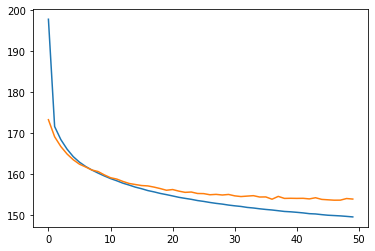

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

array([[-0.41955185, -0.9404731 ]], dtype=float32)

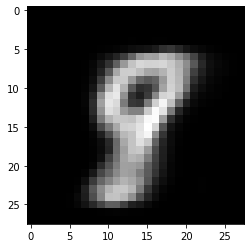

In [ ]:
random_z_from_prior = np.random.normal(size=(1, latent_dim)).astype("float32")
generated = decoder(random_z_from_prior).numpy()
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
#Ваше решение
random_z_from_prior

array([[ 0.10703415, -1.8414623 ]], dtype=float32)

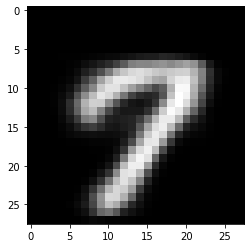

In [ ]:
random_z_from_prior = np.random.normal(size=(1, latent_dim)).astype("float32")
generated = decoder(random_z_from_prior).numpy()
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
#Ваше решение
random_z_from_prior

In [ ]:
id_to_labels = [0,1,2,3,4,5,6,7,8,9]

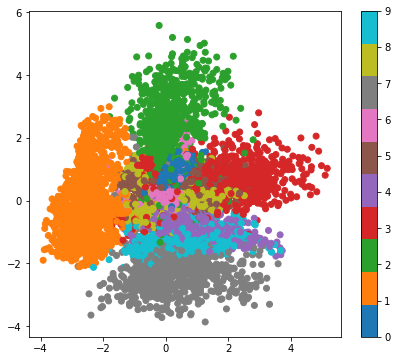

In [ ]:
x_test_encoded, x_test_encoded_log_var = encoder(x_test_standard)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels))
cb.set_ticklabels(list(id_to_labels))
cb.update_ticks()
plt.show()

В результате на данном датасете автокодировщик также показал отличные результаты, а кривые обучения говорят о хорошем качестве получаемого кодировщика. На послежним графике также можно заметить, что некоторые классы перемешаны (например 6 и 5), что говорит о трудности определения данной категории.ь Лучше всего определяются 7,1,2 и 3.

###Задание 2 Сверточный VAE

Реализуйте и исследуйте модель сверточного вариационного автокодировщика для датасета Fashion MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
x_train = (x_train / 255).astype(float)
x_test = (x_test / 255).astype(float)

In [ ]:
x_train_conv = np.expand_dims(x_train, -1)
x_test_conv = np.expand_dims(x_test, -1)
x_train_conv.shape, x_test_conv.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### Суть: напишите кодировщик, который использует ряд сверточных слоев с максимальным пулингом или шаговыми свертками и пакетной нормализацией для кодирования двумерных изображений уровня серого в двумерные скрытые векторы:

In [ ]:
from tensorflow.keras.layers import BatchNormalization

img_rows, img_cols, img_chns = 28, 28, 1
filters = 32
kernel_size = 3
intermediate_dim = 128
latent_dim = 2


def make_conv_encoder(img_rows, img_cols, img_chns,
                      latent_dim, intermediate_dim):
    x = Input(shape=(img_rows, img_cols, img_chns))
    ###fix_me###
    x_conv = Conv2D(filters,
                    kernel_size=kernel_size,
                    padding='same', activation='relu')(x)
    x_conv = BatchNormalization()(x_conv)
    x_conv = Conv2D(filters,
                    kernel_size=kernel_size,
                    padding='same', activation='relu',
                    strides=(2, 2))(x_conv)
    x_conv = BatchNormalization()(x_conv)
    x_conv = Conv2D(filters,
                    kernel_size=kernel_size,
                    padding='same', activation='relu')(x_conv)
    x_conv = BatchNormalization()(x_conv)
    x_conv = Conv2D(filters,
                    kernel_size=kernel_size,
                    padding='same', activation='relu',
                    strides=(2, 2))(x_conv)
    flat = Flatten()(x_conv)
    hidden = Dense(intermediate_dim, activation='relu')(flat)
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden)
    ###fix_me###
    return Model(inputs=x, outputs=[z_mean, z_log_var],
                 name='convolutional_encoder')


conv_encoder = make_conv_encoder(img_rows, img_cols, img_chns,
                                 latent_dim, intermediate_dim)
print(conv_encoder.summary())
conv_encoder.predict(x_train_conv[:1])

Model: "convolutional_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 32)   320         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 28, 28, 32)  128         ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 32)   9248        ['batch_norma

[array([[-0.00772706,  0.04714389]], dtype=float32),
 array([[-0.01997104,  0.00297049]], dtype=float32)]

Стохастическая скрытая переменная такая же, как и для полносвязной модели.

In [ ]:
sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,),
                        name="latent_sampler")

## Декодер

Декодер также является сверточным, но вместо понижения дискретизации пространственных измерений с (28, 28) до 2 скрытых измерений он начинает со скрытого пространства для повышения дискретизации до (28, 28) измерений с использованием чередующихся слоев Conv2DTranspose.

Здесь снова слои BatchNormalization вставляются после свертки, чтобы оптимизировать сходимость быстрее.

In [ ]:
def make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                      spatial_size=7, filters=16):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(filters * spatial_size * spatial_size, activation='relu')(x)
    x = Reshape((spatial_size, spatial_size, filters))(x)
    # Первый блок повышающей размерность дискретизации:
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        padding='same',
                        strides=(2, 2),
                        activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        padding='same',
                        strides=1,
                        activation='relu')(x)
    x = BatchNormalization()(x)
    # Первый блок повышающей размерность дискретизации:

    #Слой повышающей размерность дискретизации: padding: valid
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        strides=(2, 2),
                        padding='valid',
                        activation='relu')(x)
    x = BatchNormalization()(x)
    #Слой повышающей размерность дискретизации: padding: valid, activation: sigmoid
    # Выход 1 канала значений серых пикселей от 0 до 1:
    x = Conv2D(1, kernel_size=2, padding='valid',
               activation='sigmoid')(x)
    # Выход 1 канала значений серых пикселей от 0 до 1:
    return Model(decoder_input, x, name='convolutional_decoder')


conv_decoder = make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                                 spatial_size=7, filters=filters)
print(conv_decoder.summary())

Model: "convolutional_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_17 (Dense)            (None, 128)               384       
                                                                 
 dense_18 (Dense)            (None, 1568)              202272    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 32)       9248      
 ranspose)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                            

Сгенерируем тестовое изображение

1/1 [==============================] - 0s 118ms/step


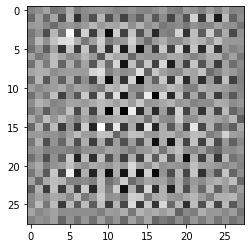

In [ ]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)

Этот новый декодер кодирует некоторые априорные знания о локальных зависимостях между значениями пикселей в архитектурах «deconv». В зависимости от случайно инициализированных весов сгенерированные изображения могут отображать некоторую локальную пространственную структуру.

Попробуйте повторно выполнить две вышеуказанные ячейки несколько раз, чтобы попытаться увидеть тип локальной структуры, вытекающей из самой архитектуры "deconv" для различных случайных инициализаций весов.

Опять же, давайте теперь соединим все вместе, чтобы получить сверточную версию полной модели VAE. Соберите полную модель VAE со сверточными кодировщиком и декодировщиком, обучите ее и исследуйте работу обученной модели

In [ ]:
input_shape = (img_rows, img_cols, img_chns)
vae = make_vae(input_shape, conv_encoder, conv_decoder,
               sampling_layer)
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 convolutional_encoder (Functio  [(None, 2),         229796      ['input[0][0]']                  
 nal)                            (None, 2)]                                                       
                                                                                                  
 latent_sampler (Lambda)        (None, 2)            0           ['convolutional_encoder[0][0]',  
                                                                  'convolutional_encoder[0][1]']  
                                                                                            

In [ ]:
vae.fit(x_train_conv, epochs=15, batch_size=100,
        validation_data=(x_test_conv, None))

Epoch 1/15
600/600 [==============================] - 7s 11ms/step - loss: 285.6085 - val_loss: 290.6169
Epoch 2/15
600/600 [==============================] - 6s 10ms/step - loss: 266.5177 - val_loss: 269.2647
Epoch 3/15
600/600 [==============================] - 6s 10ms/step - loss: 264.1476 - val_loss: 265.5481
Epoch 4/15
600/600 [==============================] - 6s 10ms/step - loss: 262.4113 - val_loss: 263.4464
Epoch 5/15
600/600 [==============================] - 6s 10ms/step - loss: 261.4961 - val_loss: 262.4162
Epoch 6/15
600/600 [==============================] - 6s 10ms/step - loss: 260.9553 - val_loss: 262.0721
Epoch 7/15
600/600 [==============================] - 6s 10ms/step - loss: 260.1732 - val_loss: 264.5741
Epoch 8/15
600/600 [==============================] - 6s 10ms/step - loss: 259.8851 - val_loss: 261.7231
Epoch 9/15
600/600 [==============================] - 6s 10ms/step - loss: 259.2916 - val_loss: 260.7792
Epoch 10/15
600/600 [==============================] - 

In [ ]:
vae.save_weights("convolutional_weights.h5")
vae.load_weights("convolutional_weights.h5")

1/1 [==============================] - 0s 17ms/step


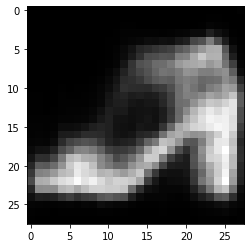

In [ ]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)

In [ ]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

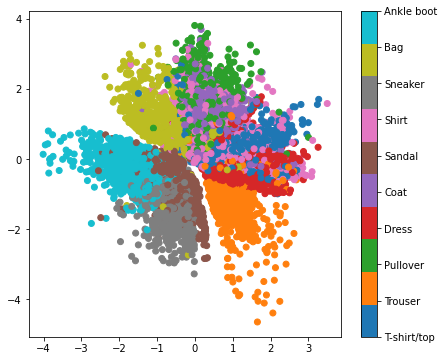

In [ ]:
x_test_encoded, _ = conv_encoder(x_test_conv)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

1/1 [==============================] - 0s 16ms/step


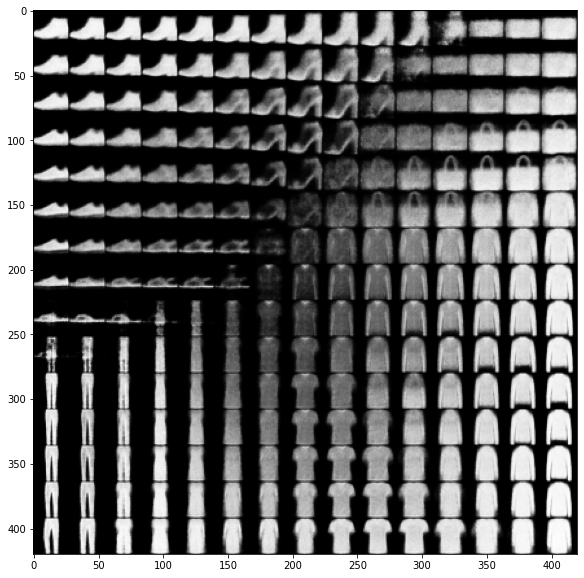

In [ ]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = conv_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

В результате с использование сверточного автоэнкодера нам также удалось представить данные в низкоразмерном пространстве. При этом при обучении на 50 эпохах мы получили результаты, которые соответвуют 300 эпохам вариационного автокодировщика, а значит применение сверточного является более эффективным при обработке изображений.